# 2024b, 22961, Mmn 13

Author: Tal Glanzman

Date: 01/05/2024

[Github Link](https://github.com/tglanz/bsc/blob/master/2024b-22961/mmn13/mmn13.ipynb)

[Youtube Link](https://youtu.be/S5NK7T8a0dA)

[Shareable link to the diabetes dataset](https://drive.google.com/file/d/1o254YK8ZkZ42Iuk145rk_VzwnBp0UO3R/view?usp=sharing)

In [9]:
from typing import List, Optional, Sequence, Set, Tuple
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt

def visualize_classes(df):
    """
    Visualize a Dataframe's Y/Class correlation through a scatter graph
    """
    fig = plt.figure()
    plt.scatter(df["Class"], df.Y)
    ax = fig.axes[0]
    ax.set_xlabel("Class")
    ax.set_ylabel("Y")
    ax.set_title("Diabetes Y Classes")

class DiabetesDataset(Dataset):
    """
    The DiabetesDataset wraps a dataframe that contains diabetes data.
    It is used to load data into our pytorch model.

    In reality, the implementation here is not specific for the diabetes data.
    The implementation is rather generic and can be used with any dataframe.
    
    When constructing the Dataset we need to specify what are the
    - "x" columns, i.e. the inputs
    - "y" column, i.e. the label, and its type

    Useful reference:
    https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
    """

    # A dataframe contains the diabetes data 
    df: pd.DataFrame

    # The names of the columns that are considered the inputs.
    x_include: Set[str]

    # The name of the label column.
    y_column: str

    # The type of the label column.
    # For classification tasks, this is probably a `torch.long`.
    # For regression tasks, this is probably a `torch.float`.
    y_dtype: torch.dtype

    def __init__(self,
                 df: pd.DataFrame,
                 x_include: Sequence[str],
                 y_column: str,
                 y_dtype: torch.dtype = torch.long,
    ):
        """
        Initialize a new DiabetesDataset object.

        Parameters
            df {pandas.Dataframe} - A dataframe to wrap.
                                    This dataset will return the data for this dataframe.
                                    
            x_include {Sequence[str]} - The name of the columns that should be retrieved
                                        as inputs.

            y_column {str} - The name of the column that should be retrieved as the label.

            y_dtype {torch.dtype} - The datatype of the `y_column`
        """
        self.df = df
        self.x_include = set(x_include)
        self.y_column = y_column
        self.y_dtype = y_dtype
        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index) -> torch.Tensor:
        """
        For a given `index`, returns a tuple of (x, y) such that `x` is is the `index`th row values
        in the columns `x_include` and `y` is the `index`th row value of the column `y_column`.
        """
        x = self.df.loc[index, (col in self.x_include for col in self.df.columns)].values
        y = self.df.loc[index, self.df.columns == self.y_column].values
        return (
            torch.tensor(x).float(),
            torch.tensor(y).squeeze().to(self.y_dtype))

class SimpleClassifier:
    """
    A simple classification model.
    """
    
    def __init__(self,
                 in_features: int,
                 out_classes: int,
                 learning_rate: float = 0.1,
    ):
        """
        Construct a new `SimpleClassifier`.

        Parameters:
            in_features {int} - The number of features to feed into the model.
                                i.e., the input dimension.

            out_classes {int} - The number of classes this classifier should classify.

            learning_rate {float} - The learning rate used in the training phase.
        """

        # Somewhat arbitrary, achieved through trial and error
        self.model = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, out_classes),
            nn.LogSoftmax(dim=1)
        )

        self.loss = nn.NLLLoss()

        self.optimizer = torch.optim.SGD(
            self.model.parameters(),
            lr=learning_rate)

    def forward_batch(self, batch, optimize: bool = True) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Feed the given `batch` to model and if `optimize` is set to true,
        adjust the model's parameters accordingly.

        We would use `optimize=True` in the training phase, and `optimize=False` for inference only.

        Returns a tuple (loss, accuracy) such that:
            loss {torch.Tensor} - The value of the loss function that we computed the gradients of
            accuracy {torch.Tensor} - The accuracy of the model (before optimization).
                                      The accuracy is calculated as the relative number of samples
                                      the model "got right".
        """
        xs, ys = batch

        if optimize:
            # new batch, zero all gradients
            self.optimizer.zero_grad()

        # compute 
        output = self.model(xs)

        # compute loss and gradients
        loss = self.loss(output, ys)
        loss.backward()

        if optimize:
            # update model parameters
            self.optimizer.step()

        # calculate the accuracy.
        # `inferred_classes` gets, from each entry in the batch the highest probability class.
        # then, we count how many classes the model got right, and divide by total classes
        # in order to normalize for a relative error.
        inferred_classes = output.argmax(dim=1)
        accuracy = (inferred_classes == ys).sum() / len(ys)

        # detach so any future operation on those tensors won't affect the computation graph.
        return loss.detach(), accuracy.detach()

    def forward(self, dataloader: DataLoader, optimize: bool = True):
        """
        Feed the entire data as given by the `dataloader` into the model in a batch by batch manner.

        For more information about `optimize`, see the `forward_batch` method.

        Returns a tuple of (loss, accuracy) which are the mean values returned from `forward_batch`.
        """
        total_batches = len(dataloader)

        # Keep track of the sum of loss and accuracy so we can return the average values later.
        loss_sum = 0
        accuracy_sum = 0

        # For each batch, feed it through the model.
        # Sum the loss and accuracies so we can return their average.
        for batch in dataloader:
            loss, accuracy = self.forward_batch(batch, optimize=optimize)
            loss_sum += loss
            accuracy_sum += accuracy

        return float(loss_sum) / total_batches, float(accuracy_sum) / total_batches

    def train(self,
              epochs: int,
              dataloader: DataLoader,
              plot: bool = False,
              plot_suptitle: Optional[str] = None,
        ):
        """
        Train the model on data provided from a given `dataloader`.

        The training is made by feeding the entire dataset into the model and optimizing it for 
        `epochs` number of times.

        For visualization purposes, set `plot` to True in order to visualize the process.

        Returns a tuple (loss, accuracy) which are the final loss and accuracy values of the model.
        """
        
        losses = torch.empty(epochs)
        accuracies = torch.empty(epochs)

        print("Training ", end="")
        for epoch in range(epochs):
            print(".", end="", flush=True)
            loss, accuracy = self.forward(dataloader)
            losses[epoch] = loss
            accuracies[epoch] = accuracy
        print()

        if plot:
            self.plot_train_results(plot_suptitle, losses, accuracies)

        return losses[-1], accuracies[-1]

    def plot_train_results(self, suptitle, losses, accuracies):
        fig = plt.figure()
        fig.suptitle(suptitle)
        plt.subplot(1, 2, 1)
        plt.title("Loss")
        plt.plot(range(len(losses)), losses)
        plt.xlabel("Epoch")

        plt.subplot(1, 2, 2)
        plt.plot(range(len(accuracies)), accuracies)
        plt.title("Accuracy")
        plt.xlabel("Epoch")

    def evaluate_model(self, dataloader: DataLoader) -> float:
        """
        Evaluate the model on given data without optimizing it 

        Returns the observed accuracy
        """
        loss, accuracy = self.forward(dataloader, optimize=False)
        return accuracy

def partition_dataframe(df: pd.DataFrame, frac: float) -> pd.DataFrame:
    """
    Uniformly draw `len(df)*frac` rows from `df` and return a tuple of two dataframes (a, b)
    such that `b` contains the drawn rows and `a = df - b`.
    """
    a = df.copy()
    b = a.sample(frac=frac)
    
    a.drop(b.index)
    a = a.reset_index()
    b = b.reset_index()

    return a, b

def train_and_evaluate(
        training_dataset: Dataset, test_dataset: Dataset,
        number_of_classes: int,
        experiment_name: str, experiment_variant: str):
    """
    A utility function:
    - Create a classifier with `number_of_classes` output classes it should classify
    - Train it on `training_dataset`
    - Evaluate it on `test_dataset`
    - Visualize the results and use `experiment_name` and `experiment_variants` in the titles
    """

    # Acquire the number of input features.
    input_features = len(training_dataset[0][0])

    # Create our classifier
    classifier = SimpleClassifier(
        in_features=input_features,
        out_classes=number_of_classes,
        learning_rate=lr)

    # Train our classifier and plot the process
    _, training_accuracy = classifier.train(
        epochs,
        DataLoader(training_dataset, batch_size),
        plot=plot,
        plot_suptitle=f"{experiment_name} - {experiment_variant}")

    # Evaluate our classifer
    test_accuracy = classifier.evaluate_model(
        DataLoader(test_dataset))

    # Print results
    print(f"Experiment: {experiment_name}, {experiment_variant}")
    print(f" - Final training accuracy: {training_accuracy}")
    print(f" - Final test accuracy: {test_accuracy}")

    # Compare value by value.
    # Used mostly for debug purposes to check whether the values makes sense.
    # For example, I previously reached sufficient accuracy, but saw that the model
    # yields only zeros.
    if print_model_vs_actual:
        for (xs, ys) in DataLoader(test_dataset, batch_size=1):
            result = classifier.model(xs)
            print(f"Model: {result[0].argmax()}, Actual: {ys[0]}")

In [10]:
# Fix training parameters
epochs = 100
plot = True
print_model_vs_actual = False
lr = 0.01
batch_size = 10

print("Epochs: ", epochs)
print("Learning Rate: ", lr)
print("Batch Size: ", batch_size)

diabetes_df = pd.read_csv("assets/diabetes.csv", sep="\t")

def run_experiments(quantiles, variant_name):
    """
    A utility function that runs two experiment variants: The first is to classify `Class`
    with the `Y` column part of the input and the other is to classify `Class` without
    the `Y` column part of the input.

    The parameter `quantiles` determines how much quantiles to distribute the `Y` column to.
    The result of the "quantiled" `Y` column is stored in the `Class` column.

    `variant_name` is given only for plotting purposes. e.g; "Deciles", "Percentages".
    """
    
    diabetes_df['Class'] = pd.qcut(diabetes_df.Y, quantiles, labels=False)

    # The training and test set contains 80% and 20% from the dataset respectively.
    training_df, test_df = partition_dataframe(diabetes_df, frac=0.2)

    training_dataset_with_y = DiabetesDataset(
        training_df,
        x_include=[col for col in diabetes_df.columns if col not in ("Class")],
        y_column="Class")

    test_dataset_with_y = DiabetesDataset(
        test_df,
        x_include=[col for col in diabetes_df.columns if col not in ("Class")],
        y_column="Class")

    training_dataset_without_y = DiabetesDataset(
        training_df,
        x_include=[col for col in diabetes_df.columns if col not in ("Class", "Y")],
        y_column="Class")

    test_dataset_without_y = DiabetesDataset(
        test_df,
        x_include=[col for col in diabetes_df.columns if col not in ("Class", "Y")],
        y_column="Class")

    # Visualize the classes
    visualize_classes(diabetes_df)

    if quantiles == 10:
        # We were asked to print the first batch.
        print(next(iter(DataLoader(training_dataset_with_y, batch_size))))

    # Train and evaluate a classifier for Class that is trained on all fields including Y
    train_and_evaluate(training_dataset_with_y, test_dataset_with_y,
                       quantiles,
                       "Predict Class with Y", variant_name)

    # Train and evaluate a classifier for Class that is trained on all fields except Y
    train_and_evaluate(training_dataset_without_y, test_dataset_without_y,
                       quantiles,
                       "Predict Class without Y", variant_name)

Epochs:  100
Learning Rate:  0.01
Batch Size:  10


[tensor([[ 59.0000,   2.0000,  32.1000, 101.0000, 157.0000,  93.2000,  38.0000,
           4.0000,   4.8598,  87.0000, 151.0000],
        [ 48.0000,   1.0000,  21.6000,  87.0000, 183.0000, 103.2000,  70.0000,
           3.0000,   3.8918,  69.0000,  75.0000],
        [ 72.0000,   2.0000,  30.5000,  93.0000, 156.0000,  93.6000,  41.0000,
           4.0000,   4.6728,  85.0000, 141.0000],
        [ 24.0000,   1.0000,  25.3000,  84.0000, 198.0000, 131.4000,  40.0000,
           5.0000,   4.8903,  89.0000, 206.0000],
        [ 50.0000,   1.0000,  23.0000, 101.0000, 192.0000, 125.4000,  52.0000,
           4.0000,   4.2905,  80.0000, 135.0000],
        [ 23.0000,   1.0000,  22.6000,  89.0000, 139.0000,  64.8000,  61.0000,
           2.0000,   4.1897,  68.0000,  97.0000],
        [ 36.0000,   2.0000,  22.0000,  90.0000, 160.0000,  99.6000,  50.0000,
           3.0000,   3.9512,  82.0000, 138.0000],
        [ 66.0000,   2.0000,  26.2000, 114.0000, 255.0000, 185.0000,  56.0000,
           4.5500

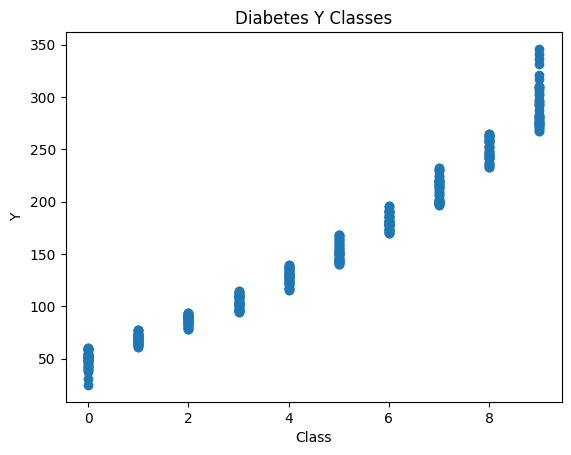

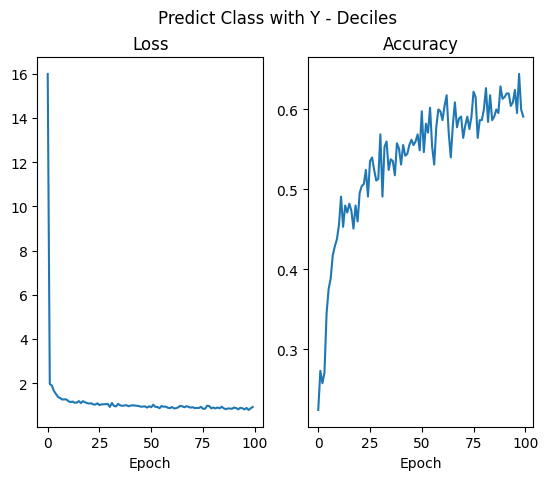

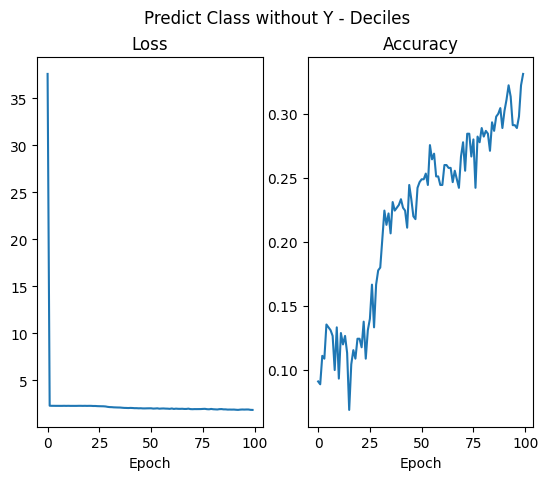

In [11]:
run_experiments(10, "Deciles")

Training ....................................................................................................
Experiment: Predict Class with Y, Percentiles
 - Final training accuracy: 0.3199999928474426
 - Final test accuracy: 0.1590909090909091
Training ....................................................................................................
Experiment: Predict Class without Y, Percentiles
 - Final training accuracy: 0.30222222208976746
 - Final test accuracy: 0.06818181818181818


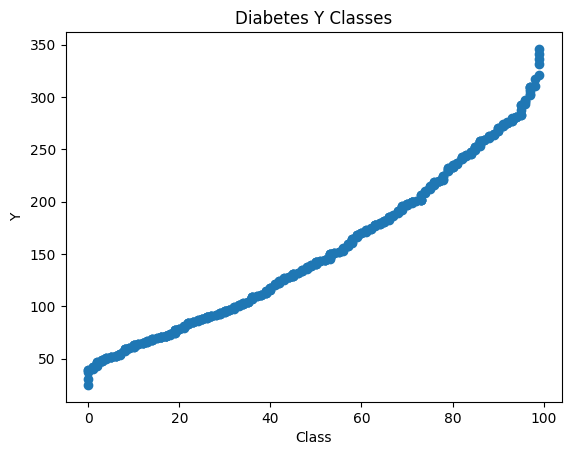

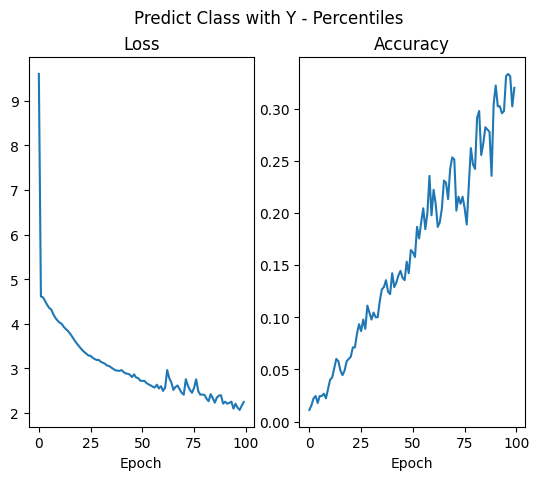

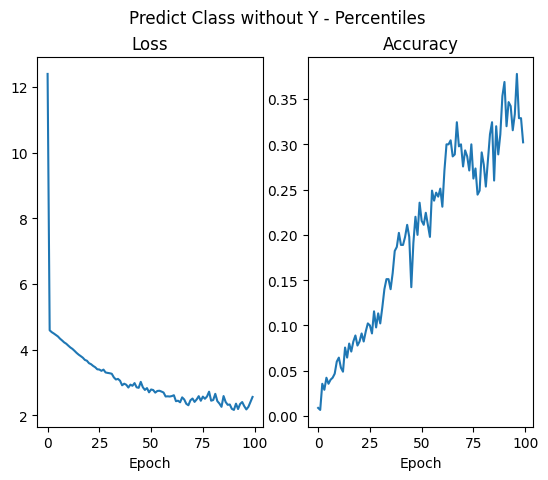

In [6]:
run_experiments(100, "Percentiles")

In [7]:
class SimpleRegression:
    """ A simple regression model """
    
    def __init__(self,
                 in_features: int,
                 learning_rate: float = 0.1,
    ):
        """
        Construct a new `SimpleRegression`.

        Parameters:
          in_features {int} - The number of input features.
          learning_rate {float} - The learning rate.
        """

        # Contrary to `SimpleClassification`, for regression we output a single value
        # which is the predicted value itself.
        # Therefore, the last layer's output dimension is 1 and is not fed to an activation.
        self.model = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, in_features),
            nn.ReLU(),
            nn.Linear(in_features, 1),
        )

        # MSE is suitable for regression tasks.
        self.loss = nn.MSELoss()

        # Use Adam optimizer instead of SGD - SGD underperforms, Adam performs well.
        self.optimizer = torch.optim.Adam(
            self.model.parameters(),
            lr=learning_rate)

    def forward_batch(self, batch, optimize: bool = True):
        """ Roughly the same as in `SimpleClassifier` """
        xs, ys = batch

        if optimize:
            # new batch, zero all gradients
            self.optimizer.zero_grad()

        # feed forwad
        output = self.model(xs).squeeze()

        # compute loss and gradients
        loss = self.loss(output, ys)
        loss.backward()

        if optimize:
            # update model parameters
            self.optimizer.step()

        # average distance 
        err = torch.abs(output - ys).mean()

        return loss.detach(), err.detach()

    def forward(self, dataloader: DataLoader, optimize: bool = True):
        """ Roughly the same as in `SimpleClassifier` """
        
        total_batches = len(dataloader)

        loss_sum = 0
        err_sum = 0

        for batch in dataloader:
            loss, err = self.forward_batch(batch, optimize=optimize)
            loss_sum += loss
            err_sum += err

        return float(loss_sum) / total_batches, float(err_sum) / total_batches

    def train(self,
              epochs: int,
              dataloader: DataLoader,
              plot: bool = False,
              plot_suptitle: Optional[str] = None,
        ):
        """ Roughly the same as in `SimpleClassifier` """
    
        losses = torch.empty(epochs)
        errors = torch.empty(epochs)

        print("Training ", end="")
        for epoch in range(epochs):
            print(".", end="", flush=True)
            loss, accuracy = self.forward(dataloader)
            losses[epoch] = loss
            errors[epoch] = accuracy
        print()

        if plot:
            self.plot_train_results(plot_suptitle, losses, errors)

        return losses[-1], errors[-1]

    def plot_train_results(self, suptitle, losses, errors):
        """ Roughly the same as in `SimpleClassifier` """
        
        fig = plt.figure()
        fig.suptitle(suptitle)
        plt.subplot(1, 2, 1)
        plt.title("Loss")
        plt.plot(range(len(losses)), losses)
        plt.xlabel("Epoch")

        plt.subplot(1, 2, 2)
        plt.plot(range(len(errors)), errors)
        plt.title("Error")
        plt.xlabel("Epoch")

    def evaluate_model(self, dataloader: DataLoader) -> float:
        """
        Roughly the same as in `SimpleClassifier`

        Minor difference here is that we return the error instead of the accuracy.
        """
        _, err = self.forward(dataloader, optimize=False)
        return err 

Epochs:  100
Learning Rate:  0.01
Batch Size:  10
Training ....................................................................................................
Experiment: Y Regression
 - Final training error: 47.38992691040039
 - Final test error: 58.19133843315972


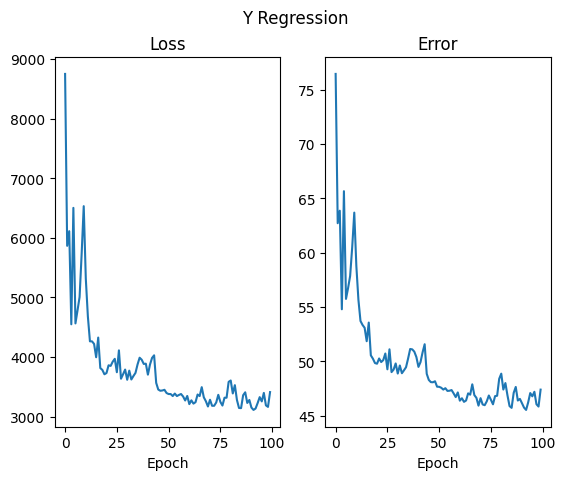

In [8]:
# This section is roughly the same as we did in the previous section only we
# perform a single experiment here.

# Configure parameters for the 
epochs = 100
plot = True
print_model_vs_actual = False
lr = 0.01
batch_size = 10

print("Epochs: ", epochs)
print("Learning Rate: ", lr)
print("Batch Size: ", batch_size)

diabetes_df = pd.read_csv("assets/diabetes.csv", sep="\t")

training_df, test_df = partition_dataframe(diabetes_df, frac=0.2)

training_dataset_for_regression = DiabetesDataset(
    training_df,
    x_include=(col for col in training_df.columns if col != 'Y'),
    y_column='Y', y_dtype=torch.float)

test_dataset_for_regression = DiabetesDataset(
    test_df,
    x_include=(col for col in training_df.columns if col != 'Y'),
    y_column='Y', y_dtype=torch.float)

regression = SimpleRegression(len(training_df.columns) - 1, learning_rate=lr)

train_loss, train_err = regression.train(
    epochs, DataLoader(training_dataset_for_regression, batch_size), plot, "Y Regression")

test_err = regression.evaluate_model(DataLoader(test_dataset_for_regression, batch_size))

print(f"Experiment: Y Regression")
print(f" - Final training error: {train_err}")
print(f" - Final test error: {test_err}")

if print_model_vs_actual:
    for (xs, ys) in DataLoader(test_dataset_for_regression, batch_size=1):
        result = regression.model(xs)
        print(f"Model: {result[0].item()}, Actual: {ys[0]}")